In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import seaborn as sns
from IPython.display import clear_output, display
import time
import os
from typing import Tuple, List

# Import surrogate functions from the utils
import sys
sys.path.append('..')
from nugget.utils.surrogates import SkewedGaussian

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for gifs
os.makedirs("nn_test_outputs", exist_ok=True)

Using device: cpu


In [2]:
class MultiGaussianSurrogate:
    """
    Generate surrogate functions as superposition of multiple randomly parameterized Gaussians
    """
    def __init__(self, dim=3, domain_size=2.0, device=None):
        self.dim = dim
        self.domain_size = domain_size
        self.half_domain = domain_size / 2
        self.device = device if device is not None else torch.device("cpu")
        
    def generate_gaussian_components(self, num_gaussians=10):
        """Generate parameters for multiple Gaussian components"""
        components = []
        
        for _ in range(num_gaussians):
            # Random amplitude
            amp = torch.rand(1, device=self.device) * 2.0 + 0.1  # [0.1, 2.1]
            
            # Random center position
            center = torch.rand(self.dim, device=self.device) * self.domain_size - self.half_domain
            
            # Random covariance matrix (making it positive definite)
            # Generate random widths for each dimension
            widths = torch.rand(self.dim, device=self.device) * 0.3 + 0.05  # [0.05, 0.35]
            
            # Create diagonal covariance matrix (can be extended to full covariance)
            cov = torch.diag(widths ** 2)
            
            components.append({
                'amp': amp,
                'center': center,
                'cov': cov,
                'cov_inv': torch.inverse(cov),
                'cov_det': torch.det(cov)
            })
            
        return components
    
    def evaluate_function(self, points, components):
        """
        Evaluate the multi-Gaussian function at given points
        
        Parameters:
        -----------
        points : torch.Tensor
            Points to evaluate at (N, dim)
        components : list
            List of Gaussian component parameters
            
        Returns:
        --------
        torch.Tensor
            Function values at the points (N,)
        """
        if points.dim() == 1:
            points = points.unsqueeze(0)
            
        total_value = torch.zeros(points.shape[0], device=self.device)
        
        for comp in components:
            # Calculate Gaussian contribution
            diff = points - comp['center'].unsqueeze(0)  # (N, dim)
            
            # Quadratic form: (x-mu)^T * Sigma^-1 * (x-mu)
            quad_form = torch.sum(diff @ comp['cov_inv'] * diff, dim=1)  # (N,)
            
            # Gaussian function
            gaussian_val = comp['amp'] * torch.exp(-0.5 * quad_form)
            total_value += gaussian_val.squeeze()
            
        return total_value
    
    def generate_background_function(self, num_gaussians=10):
        """Generate a background function (broader, lower amplitude, concentrated on left side)"""
        components = []
        
        for _ in range(num_gaussians):
            # Lower, more uniform amplitudes for background
            amp = torch.rand(1, device=self.device) * 0.3 + 0.1  # [0.1, 0.4]
            
            # Center positions concentrated on left side of domain
            center = torch.zeros(self.dim, device=self.device)
            center[0] = torch.rand(1, device=self.device) * self.half_domain/2 - self.half_domain  # x: [-1, -0.5]
            for i in range(1, self.dim):
                center[i] = torch.rand(1, device=self.device) * self.domain_size - self.half_domain  # y,z: [-1, 1]
            
            # Much broader widths for background
            widths = torch.rand(self.dim, device=self.device) * 0.6 + 0.3  # [0.3, 0.9]
            cov = torch.diag(widths ** 2)
            
            components.append({
                'amp': amp,
                'center': center,
                'cov': cov,
                'cov_inv': torch.inverse(cov),
                'cov_det': torch.det(cov)
            })
            
        return components
    
    def generate_signal_function(self, num_gaussians=10):
        """Generate a signal function (narrower, higher amplitude, concentrated on right side)"""
        components = []
        
        for _ in range(num_gaussians):
            # Much higher amplitudes for signal
            amp = torch.rand(1, device=self.device) * 0.3 + 0.1  # [0.1, 0.6]
            
            # Center positions concentrated on right side of domain
            center = torch.zeros(self.dim, device=self.device)
            center[0] = torch.rand(1, device=self.device) * self.half_domain/2 + self.half_domain/2  # x: [0.5, 1]
            for i in range(1, self.dim):
                center[i] = torch.rand(1, device=self.device) * self.domain_size - self.half_domain  # y,z: [-1, 1]
            
            # Much narrower widths for signal
            widths = torch.rand(self.dim, device=self.device) * 0.6 + 0.3  # [0.05, 0.2]
            cov = torch.diag(widths ** 2)
            
            components.append({
                'amp': amp,
                'center': center,
                'cov': cov,
                'cov_inv': torch.inverse(cov),
                'cov_det': torch.det(cov)
            })
            
        return components

In [3]:
class MLPClassifier(nn.Module):
    """
    Multi-Layer Perceptron for binary classification
    
    Input: (x, y, z, light_yield) -> 4D feature vector
    Output: probability of being signal (0 = background, 1 = signal)
    """
    def __init__(self, input_dim=4, hidden_dims=[128, 64, 32], dropout_prob=0.2):
        super(MLPClassifier, self).__init__()
        
        layers = []
        current_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            current_dim = hidden_dim
        
        # Output layer with sigmoid activation
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
    def predict_log_likelihood_ratio(self, x):
        """
        Compute log(p/(1-p)) where p is the network output
        This approximates the log likelihood ratio
        """
        p = self.forward(x)
        # Clamp to avoid numerical issues
        p = torch.clamp(p, 1e-7, 1 - 1e-7)
        return torch.log(p / (1 - p))

In [4]:
def generate_training_data(surrogate_generator, background_components, signal_components, 
                          n_samples=10000, noise_std=0.1):
    """
    Generate training data by sampling from the surrogate functions
    
    Parameters:
    -----------
    surrogate_generator : MultiGaussianSurrogate
        The surrogate function generator
    background_components : list
        Background function components
    signal_components : list
        Signal function components
    n_samples : int
        Number of samples to generate for each class
    noise_std : float
        Standard deviation for Gaussian noise added to the function values
        
    Returns:
    --------
    X : torch.Tensor
        Feature matrix (position + light_yield)
    y : torch.Tensor
        Labels (0 = background, 1 = signal)
    """
    # Generate random 3D positions
    positions = torch.rand(2 * n_samples, surrogate_generator.dim, device=device) * \
                surrogate_generator.domain_size - surrogate_generator.half_domain
    
    # Split positions for background and signal
    bg_positions = positions[:n_samples]
    sig_positions = positions[n_samples:]
    
    # Evaluate background function at background positions
    bg_light_yield = surrogate_generator.evaluate_function(bg_positions, background_components)
    # Add Gaussian noise
    bg_light_yield += torch.randn_like(bg_light_yield) * noise_std
    bg_light_yield = torch.clamp(bg_light_yield, min=0)  # Ensure non-negative
    
    # Evaluate signal function at signal positions
    sig_light_yield = surrogate_generator.evaluate_function(sig_positions, signal_components)
    # Add Gaussian noise
    sig_light_yield += torch.randn_like(sig_light_yield) * noise_std
    sig_light_yield = torch.clamp(sig_light_yield, min=0)  # Ensure non-negative
    
    # Combine features: [x, y, z, light_yield]
    bg_features = torch.cat([bg_positions, bg_light_yield.unsqueeze(1)], dim=1)
    sig_features = torch.cat([sig_positions, sig_light_yield.unsqueeze(1)], dim=1)
    
    # Combine all features and labels
    X = torch.cat([bg_features, sig_features], dim=0)
    y = torch.cat([torch.zeros(n_samples, device=device), torch.ones(n_samples, device=device)], dim=0)
    
    # Shuffle the data
    indices = torch.randperm(2 * n_samples, device=device)
    X = X[indices]
    y = y[indices]
    
    return X, y

def compute_true_likelihood_ratio(positions, light_yields, background_components, signal_components, 
                                surrogate_generator, noise_std=0.1):
    """
    Compute the true likelihood ratio assuming Gaussian noise
    
    Parameters:
    -----------
    positions : torch.Tensor
        3D positions
    light_yields : torch.Tensor
        Observed light yields
    background_components : list
        Background function components
    signal_components : list
        Signal function components
    surrogate_generator : MultiGaussianSurrogate
        The surrogate function generator
    noise_std : float
        Standard deviation of the Gaussian noise
        
    Returns:
    --------
    torch.Tensor
        True log likelihood ratio
    """
    # Evaluate true functions at positions
    bg_mean = surrogate_generator.evaluate_function(positions, background_components)
    sig_mean = surrogate_generator.evaluate_function(positions, signal_components)
    
    # Compute log-likelihoods assuming Gaussian noise
    # log P(light_yield | background) = -0.5 * (light_yield - bg_mean)^2 / noise_std^2 + const
    # log P(light_yield | signal) = -0.5 * (light_yield - sig_mean)^2 / noise_std^2 + const
    
    log_bg_likelihood = -0.5 * (light_yields - bg_mean) ** 2 / (noise_std ** 2)
    log_sig_likelihood = -0.5 * (light_yields - sig_mean) ** 2 / (noise_std ** 2)
    
    # Log likelihood ratio
    log_ratio = log_sig_likelihood - log_bg_likelihood
    
    return log_ratio

In [5]:
def plot_loss_and_likelihood_comparison(losses, epoch, model, test_positions, test_light_yields,
                                       true_log_ratios, background_components, signal_components,
                                       surrogate_generator, test_labels, save_frame=False):
    """
    Plot loss evolution and likelihood ratio comparison with labeled data points
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Loss evolution
    axes[0, 0].clear()
    axes[0, 0].plot(losses, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title(f'Training Loss (Epoch {epoch})')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: NN vs True likelihood ratio scatter
    with torch.no_grad():
        test_features = torch.cat([test_positions, test_light_yields.unsqueeze(1)], dim=1)
        nn_log_ratios = model.predict_log_likelihood_ratio(test_features).squeeze().cpu().numpy()
        true_ratios_cpu = true_log_ratios.cpu().numpy()
    
    axes[0, 1].clear()
    # Color points by true labels
    labels_cpu = test_labels.cpu().numpy()
    bg_mask = (labels_cpu == 0) & (np.abs(nn_log_ratios) < 5)  # Background points
    sig_mask = (labels_cpu == 1) & (np.abs(nn_log_ratios) < 5)
    
    axes[0, 1].scatter(true_ratios_cpu[bg_mask], nn_log_ratios[bg_mask], 
                      alpha=0.6, s=15, c='blue', label='Background', marker='o')
    axes[0, 1].scatter(true_ratios_cpu[sig_mask], nn_log_ratios[sig_mask], 
                      alpha=0.6, s=15, c='red', label='Signal', marker='^')
    
    mask = np.abs(nn_log_ratios) < 5  # Filter out extreme values for better visualization
    # min_val = min(true_ratios_cpu[mask].min(), nn_log_ratios[mask].min())
    # max_val = max(true_ratios_cpu[mask].max(), nn_log_ratios[mask].max())
    # min_val = nn_log_ratios.min()
    # max_val = nn_log_ratios.max()
    min_val = -5
    max_val = 5
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Agreement')
    axes[0, 1].set_xlabel('True Log Likelihood Ratio')
    axes[0, 1].set_ylabel('NN Log Likelihood Ratio')
    axes[0, 1].set_title('NN vs True Likelihood Ratio')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Create a 2D grid for visualization and average over multiple z slices
    x_range = torch.linspace(-surrogate_generator.half_domain, surrogate_generator.half_domain, 60)
    y_range = torch.linspace(-surrogate_generator.half_domain, surrogate_generator.half_domain, 60)
    X_grid, Y_grid = torch.meshgrid(x_range, y_range, indexing='ij')
    
    # Define z slices to average over (using fewer slices for faster computation)
    z_slices = torch.linspace(-surrogate_generator.half_domain, surrogate_generator.half_domain, 20)
    
    # Initialize arrays to accumulate results
    true_grid_ratios_sum = np.zeros((60, 60))
    nn_grid_ratios_sum = np.zeros((60, 60))
    
    # Average over multiple z slices
    for z_val in z_slices:
        # Create positions for this z slice
        Z_slice = torch.full_like(X_grid, z_val)
        positions_slice = torch.stack([X_grid.flatten(), Y_grid.flatten(), Z_slice.flatten()], dim=1).to(device)
        
        # Compute light yields at each grid point based on both background and signal components
        # Use the average of background and signal light yields as a reasonable estimate
        bg_light_yields = surrogate_generator.evaluate_function(positions_slice, background_components)
        sig_light_yields = surrogate_generator.evaluate_function(positions_slice, signal_components)
        light_yields_slice = (bg_light_yields + sig_light_yields) / 2.0
        light_yields_slice = torch.clamp(light_yields_slice, min=0)  # Ensure non-negative
        
        # Compute true likelihood ratios for this slice
        true_slice_ratios = compute_true_likelihood_ratio(positions_slice, light_yields_slice, 
                                                         background_components, signal_components,
                                                         surrogate_generator).cpu().numpy().reshape(60, 60)
        
        # Compute NN likelihood ratios for this slice
        with torch.no_grad():
            slice_features = torch.cat([positions_slice, light_yields_slice.unsqueeze(1)], dim=1)
            nn_slice_ratios = model.predict_log_likelihood_ratio(slice_features).squeeze().cpu().numpy().reshape(60, 60)
        
        # Accumulate results
        true_grid_ratios_sum += true_slice_ratios
        nn_grid_ratios_sum += nn_slice_ratios
    
    # Take average over all slices
    true_grid_ratios = true_grid_ratios_sum / len(z_slices)
    nn_grid_ratios = nn_grid_ratios_sum / len(z_slices)
    
    # Get test data points near the central z region for overlay
    z_coords = test_positions[:, 2].cpu().numpy()
    z_near_center = np.abs(z_coords) < 0.3  # Points within the z range we're averaging over
    
    x_test = test_positions[z_near_center, 0].cpu().numpy()
    y_test = test_positions[z_near_center, 1].cpu().numpy()
    labels_near_center = test_labels[z_near_center].cpu().numpy()
    
    # Get log likelihood ratios for the points near the central z region
    true_lr_near_center = true_log_ratios[z_near_center].cpu().numpy()
    
    # Compute NN log likelihood ratios for points near the central z region
    with torch.no_grad():
        test_features_near_center = torch.cat([test_positions[z_near_center], test_light_yields[z_near_center].unsqueeze(1)], dim=1)
        nn_lr_near_center = model.predict_log_likelihood_ratio(test_features_near_center).squeeze().cpu().numpy()
    
    # Plot 3: True likelihood ratio iso-contours with data points
    axes[1, 0].clear()
    
    # Determine global min/max for consistent color scale across both plots
    global_min = min(true_grid_ratios.min(), nn_grid_ratios.min())
    global_max = max(true_grid_ratios.max(), nn_grid_ratios.max())
    contour_levels = np.linspace(global_min, global_max, 12)
    
    # Plot filled contours for background
    contour_filled = axes[1, 0].contourf(X_grid.cpu().numpy(), Y_grid.cpu().numpy(), true_grid_ratios, 
                                        levels=contour_levels, cmap='viridis', alpha=0.6, 
                                        vmin=global_min, vmax=global_max)
    
    # Plot contour lines
    contour_lines = axes[1, 0].contour(X_grid.cpu().numpy(), Y_grid.cpu().numpy(), true_grid_ratios, 
                                      levels=contour_levels[::2], colors='black', linewidths=1.0, alpha=0.8)
    axes[1, 0].clabel(contour_lines, inline=True, fontsize=7, fmt='%.1f')
    
    # Add colorbar for contours
    cbar_contour1 = plt.colorbar(contour_filled, ax=axes[1, 0], shrink=0.6, pad=0.15)
    cbar_contour1.set_label('True Log LR (Contours)', fontsize=8)
    
    # Separate data points by label for different shapes
    bg_mask_slice = labels_near_center == 0
    sig_mask_slice = labels_near_center == 1
    
    # Plot background points (circles) colored by their true log LR values
    if np.any(bg_mask_slice):
        scatter1_bg = axes[1, 0].scatter(x_test[bg_mask_slice], y_test[bg_mask_slice], 
                                        c=true_lr_near_center[bg_mask_slice], s=40, alpha=0.9, 
                                        cmap='RdYlBu_r', marker='o', edgecolors='black', linewidth=0.5,
                                        label='Background')
    
    # Plot signal points (triangles) colored by their true log LR values  
    if np.any(sig_mask_slice):
        scatter1_sig = axes[1, 0].scatter(x_test[sig_mask_slice], y_test[sig_mask_slice], 
                                         c=true_lr_near_center[sig_mask_slice], s=40, alpha=0.9, 
                                         cmap='RdYlBu_r', marker='^', edgecolors='black', linewidth=0.5,
                                         label='Signal')
    
    # Add colorbar for data points
    # Use the scatter plot with more data points for better colorbar
    if np.any(bg_mask_slice) and np.any(sig_mask_slice):
        cbar_data1 = plt.colorbar(scatter1_bg, ax=axes[1, 0], shrink=0.6, pad=0.02)
    elif np.any(bg_mask_slice):
        cbar_data1 = plt.colorbar(scatter1_bg, ax=axes[1, 0], shrink=0.6, pad=0.02)
    elif np.any(sig_mask_slice):
        cbar_data1 = plt.colorbar(scatter1_sig, ax=axes[1, 0], shrink=0.6, pad=0.02)
    
    if 'cbar_data1' in locals():
        cbar_data1.set_label('Data Log LR', fontsize=8)
    
    axes[1, 0].set_xlabel('X')
    axes[1, 0].set_ylabel('Y')
    axes[1, 0].set_title(f'True Log LR (z-avg, Position-dep LY)')
    axes[1, 0].set_aspect('equal')
    axes[1, 0].legend(fontsize=8, loc='upper right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: NN likelihood ratio iso-contours with data points
    axes[1, 1].clear()
    
    # Plot filled contours for background using the same global levels
    nn_contour_filled = axes[1, 1].contourf(X_grid.cpu().numpy(), Y_grid.cpu().numpy(), nn_grid_ratios, 
                                           levels=contour_levels, cmap='viridis', alpha=0.6,
                                           vmin=global_min, vmax=global_max)
    
    # Plot contour lines
    nn_contour_lines = axes[1, 1].contour(X_grid.cpu().numpy(), Y_grid.cpu().numpy(), nn_grid_ratios, 
                                         levels=contour_levels[::2], colors='black', linewidths=1.0, alpha=0.8)
    axes[1, 1].clabel(nn_contour_lines, inline=True, fontsize=7, fmt='%.1f')
    
    # Add colorbar for contours
    cbar_contour2 = plt.colorbar(nn_contour_filled, ax=axes[1, 1], shrink=0.6, pad=0.15)
    cbar_contour2.set_label('NN Log LR (Contours)', fontsize=8)
    
    # Plot background points (circles) colored by their NN log LR values
    if np.any(bg_mask_slice):
        scatter2_bg = axes[1, 1].scatter(x_test[bg_mask_slice], y_test[bg_mask_slice], 
                                        c=nn_lr_near_center[bg_mask_slice], s=40, alpha=0.9, 
                                        cmap='RdYlBu_r', marker='o', edgecolors='black', linewidth=0.5,
                                        label='Background')
    
    # Plot signal points (triangles) colored by their NN log LR values
    if np.any(sig_mask_slice):
        scatter2_sig = axes[1, 1].scatter(x_test[sig_mask_slice], y_test[sig_mask_slice], 
                                         c=nn_lr_near_center[sig_mask_slice], s=40, alpha=0.9, 
                                         cmap='RdYlBu_r', marker='^', edgecolors='black', linewidth=0.5,
                                         label='Signal')
    
    # Add colorbar for data points
    if np.any(bg_mask_slice) and np.any(sig_mask_slice):
        cbar_data2 = plt.colorbar(scatter2_bg, ax=axes[1, 1], shrink=0.6, pad=0.02)
    elif np.any(bg_mask_slice):
        cbar_data2 = plt.colorbar(scatter2_bg, ax=axes[1, 1], shrink=0.6, pad=0.02)
    elif np.any(sig_mask_slice):
        cbar_data2 = plt.colorbar(scatter2_sig, ax=axes[1, 1], shrink=0.6, pad=0.02)
    
    if 'cbar_data2' in locals():
        cbar_data2.set_label('Data Log LR', fontsize=8)
    
    axes[1, 1].set_xlabel('X')
    axes[1, 1].set_ylabel('Y')
    axes[1, 1].set_title(f'NN Log LR (z-avg, Position-dep LY)')
    axes[1, 1].set_aspect('equal')
    axes[1, 1].legend(fontsize=8, loc='upper right')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_frame:
        plt.savefig(f'nn_test_outputs/frame_{epoch:04d}.png', dpi=100, bbox_inches='tight')
    
    plt.show()
    
    return fig

def create_gif_from_frames(output_path='nn_test_outputs/training_evolution.gif', fps=2):
    """Create GIF from saved frames"""
    import glob
    from PIL import Image
    
    # Get all frame files
    frame_files = sorted(glob.glob('nn_test_outputs/frame_*.png'))
    
    if not frame_files:
        print("No frames found to create GIF")
        return
    
    # Read images
    images = []
    for filename in frame_files:
        images.append(Image.open(filename))
    
    # Save as GIF
    images[0].save(output_path, save_all=True, append_images=images[1:], 
                   duration=int(1000/fps), loop=0)
    
    print(f"GIF saved to {output_path}")
    
    # Clean up individual frames
    for filename in frame_files:
        os.remove(filename)

In [6]:
# Configuration parameters
config = {
    'dim': 3,
    'domain_size': 2.0,
    'num_gaussians': 10,
    'n_train_samples': 15000,
    'n_test_samples': 2000,
    'noise_std': 0.1,
    'hidden_dims': [128, 64, 32],
    'dropout_prob': 0.2,
    'learning_rate': 0.001,
    'num_epochs': 200,
    'batch_size': 256,
    'plot_every': 10,
    'save_gif': True
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")
print(f"\nDevice: {device}")
print("-" * 50)

Configuration:
  dim: 3
  domain_size: 2.0
  num_gaussians: 10
  n_train_samples: 15000
  n_test_samples: 2000
  noise_std: 0.1
  hidden_dims: [128, 64, 32]
  dropout_prob: 0.2
  learning_rate: 0.001
  num_epochs: 200
  batch_size: 256
  plot_every: 10
  save_gif: True

Device: cpu
--------------------------------------------------


In [7]:
# Initialize surrogate function generator
print("Initializing surrogate function generator...")
surrogate_gen = MultiGaussianSurrogate(dim=config['dim'], 
                                     domain_size=config['domain_size'], 
                                     device=device)

# Generate background and signal functions
print("Generating background and signal surrogate functions...")
background_components = surrogate_gen.generate_background_function(num_gaussians=config['num_gaussians'])
signal_components = surrogate_gen.generate_signal_function(num_gaussians=config['num_gaussians'])

print(f"Background function: {len(background_components)} Gaussian components")
print(f"Signal function: {len(signal_components)} Gaussian components")

# Generate training data
print(f"\nGenerating {config['n_train_samples']} training samples for each class...")
X_train, y_train = generate_training_data(surrogate_gen, background_components, signal_components,
                                        n_samples=config['n_train_samples'], 
                                        noise_std=config['noise_std'])

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Background samples: {(y_train == 0).sum().item()}")
print(f"Signal samples: {(y_train == 1).sum().item()}")

# Generate test data for evaluation
print(f"\nGenerating {config['n_test_samples']} test samples for each class...")
X_test, y_test = generate_training_data(surrogate_gen, background_components, signal_components,
                                      n_samples=config['n_test_samples'], 
                                      noise_std=config['noise_std'])

# Extract positions and light yields for test data
test_positions = X_test[:, :3]  # x, y, z
test_light_yields = X_test[:, 3]  # light yield

# Compute true likelihood ratios for test data
print("Computing true likelihood ratios for test data...")
true_log_ratios = compute_true_likelihood_ratio(test_positions, test_light_yields, 
                                              background_components, signal_components,
                                              surrogate_gen, noise_std=config['noise_std'])

print(f"Test data shape: {X_test.shape}")
print(f"True log ratios range: [{true_log_ratios.min():.3f}, {true_log_ratios.max():.3f}]")
print("-" * 50)

Initializing surrogate function generator...
Generating background and signal surrogate functions...
Background function: 10 Gaussian components
Signal function: 10 Gaussian components

Generating 15000 training samples for each class...
Training data shape: torch.Size([30000, 4])
Training labels shape: torch.Size([30000])
Background samples: 15000
Signal samples: 15000

Generating 2000 test samples for each class...
Computing true likelihood ratios for test data...
Test data shape: torch.Size([4000, 4])
True log ratios range: [-98.353, 84.680]
--------------------------------------------------


In [8]:
# Initialize the neural network
print("Initializing MLP classifier...")
input_dim = 4  # x, y, z, light_yield
model = MLPClassifier(input_dim=input_dim, 
                     hidden_dims=config['hidden_dims'], 
                     dropout_prob=config['dropout_prob']).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# Print model architecture
print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Create data loaders
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"\nTraining batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print("-" * 50)

Initializing MLP classifier...
Model architecture:
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Total parameters: 11,009

Training batches: 118
Test batches: 16
--------------------------------------------------
Model architecture:
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): R

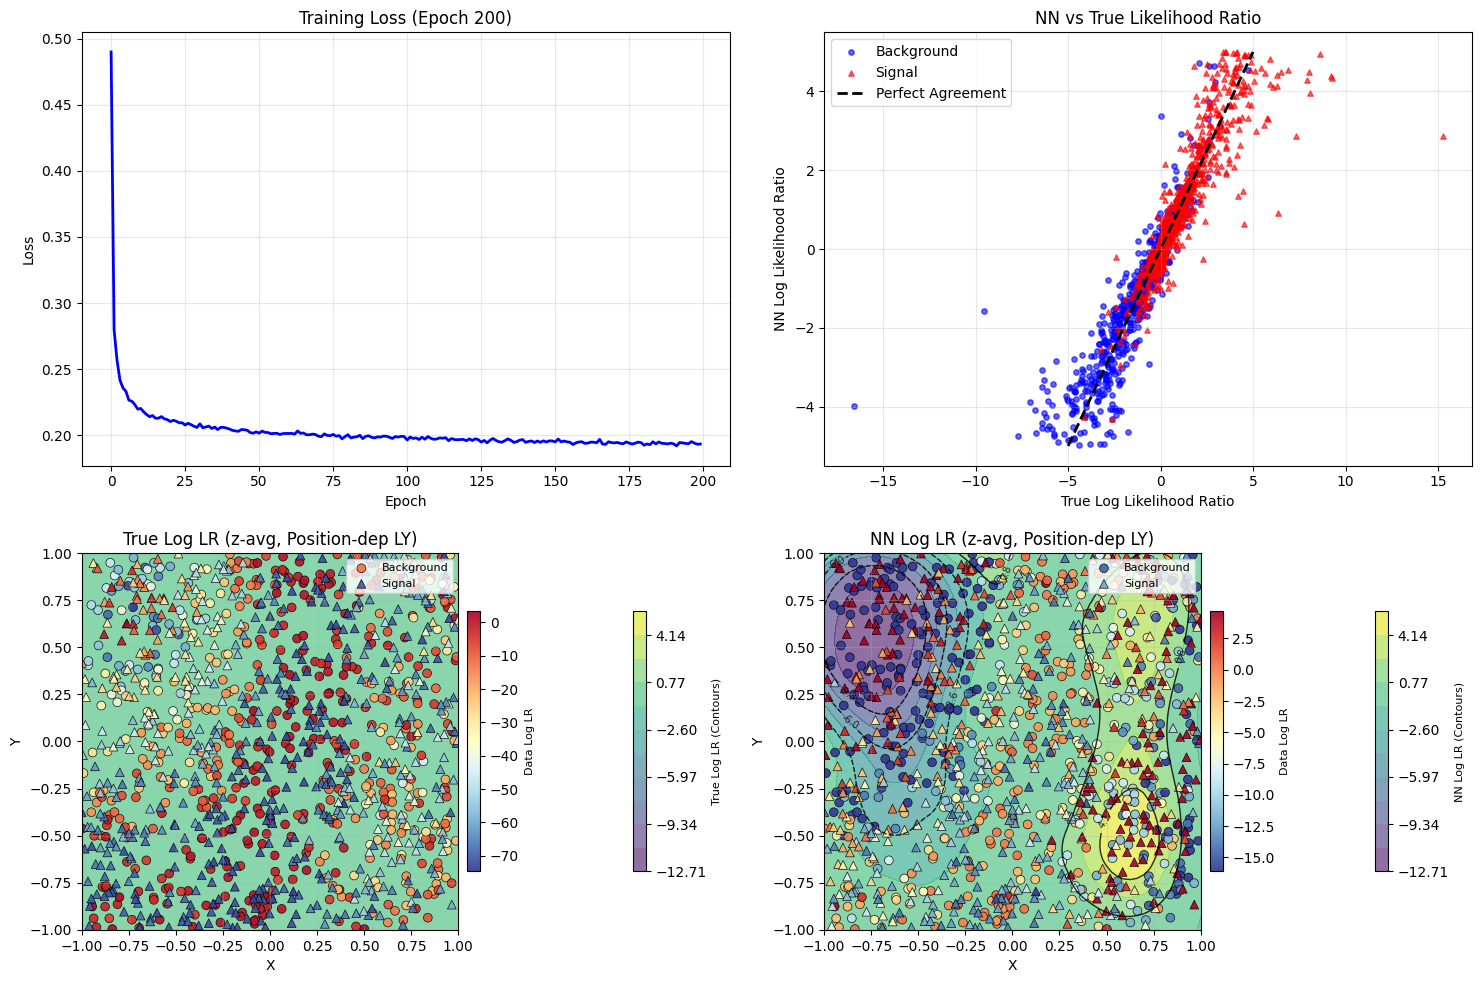

Epoch 200/200 | Loss: 0.1933 | Test Acc: 0.894 | Correlation: 0.892 | Time: 55.8s
\nTraining completed!
Total training time: 56.8 seconds
Creating training evolution GIF...
GIF saved to nn_test_outputs/training_evolution.gif
GIF saved to nn_test_outputs/training_evolution.gif


In [9]:
# Training loop with dynamic visualization
print("Starting training...")
print("=" * 60)

losses = []
start_time = time.time()

for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    
    # Evaluation phase
    if (epoch + 1) % config['plot_every'] == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            # Calculate test accuracy
            test_outputs = model(X_test).squeeze()
            test_predictions = (test_outputs > 0.5).float()
            test_accuracy = (test_predictions == y_test).float().mean().item()
            
            # Calculate correlation between NN and true likelihood ratios
            nn_log_ratios = model.predict_log_likelihood_ratio(X_test).squeeze()
            correlation = torch.corrcoef(torch.stack([true_log_ratios, nn_log_ratios]))[0, 1].item()
        
        # Print progress
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1:3d}/{config['num_epochs']} | "
              f"Loss: {epoch_loss:.4f} | "
              f"Test Acc: {test_accuracy:.3f} | "
              f"Correlation: {correlation:.3f} | "
              f"Time: {elapsed_time:.1f}s")
        
        # Clear output and plot
        clear_output(wait=True)
        
        # Create visualization
        save_frame = config['save_gif'] and ((epoch + 1) % config['plot_every'] == 0)
        fig = plot_loss_and_likelihood_comparison(losses, epoch + 1, model, test_positions, 
                                                test_light_yields, true_log_ratios,
                                                background_components, signal_components,
                                                surrogate_gen, y_test, save_frame=save_frame)
        
        # Print progress again after clearing
        print(f"Epoch {epoch+1:3d}/{config['num_epochs']} | "
              f"Loss: {epoch_loss:.4f} | "
              f"Test Acc: {test_accuracy:.3f} | "
              f"Correlation: {correlation:.3f} | "
              f"Time: {elapsed_time:.1f}s")

print("\\nTraining completed!")
total_time = time.time() - start_time
print(f"Total training time: {total_time:.1f} seconds")

# Create GIF if requested
if config['save_gif']:
    print("Creating training evolution GIF...")
    create_gif_from_frames()
    
print("=" * 60)

FINAL EVALUATION
Final Test Accuracy: 0.8938
Final Correlation (True vs NN Log Ratios): 0.8919
MSE of Log Likelihood Ratios: 243.8689

Classification Report:
              precision    recall  f1-score   support

  Background       0.88      0.91      0.90      2000
      Signal       0.91      0.88      0.89      2000

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000

Confusion Matrix:
[[1822  178]
 [ 247 1753]]


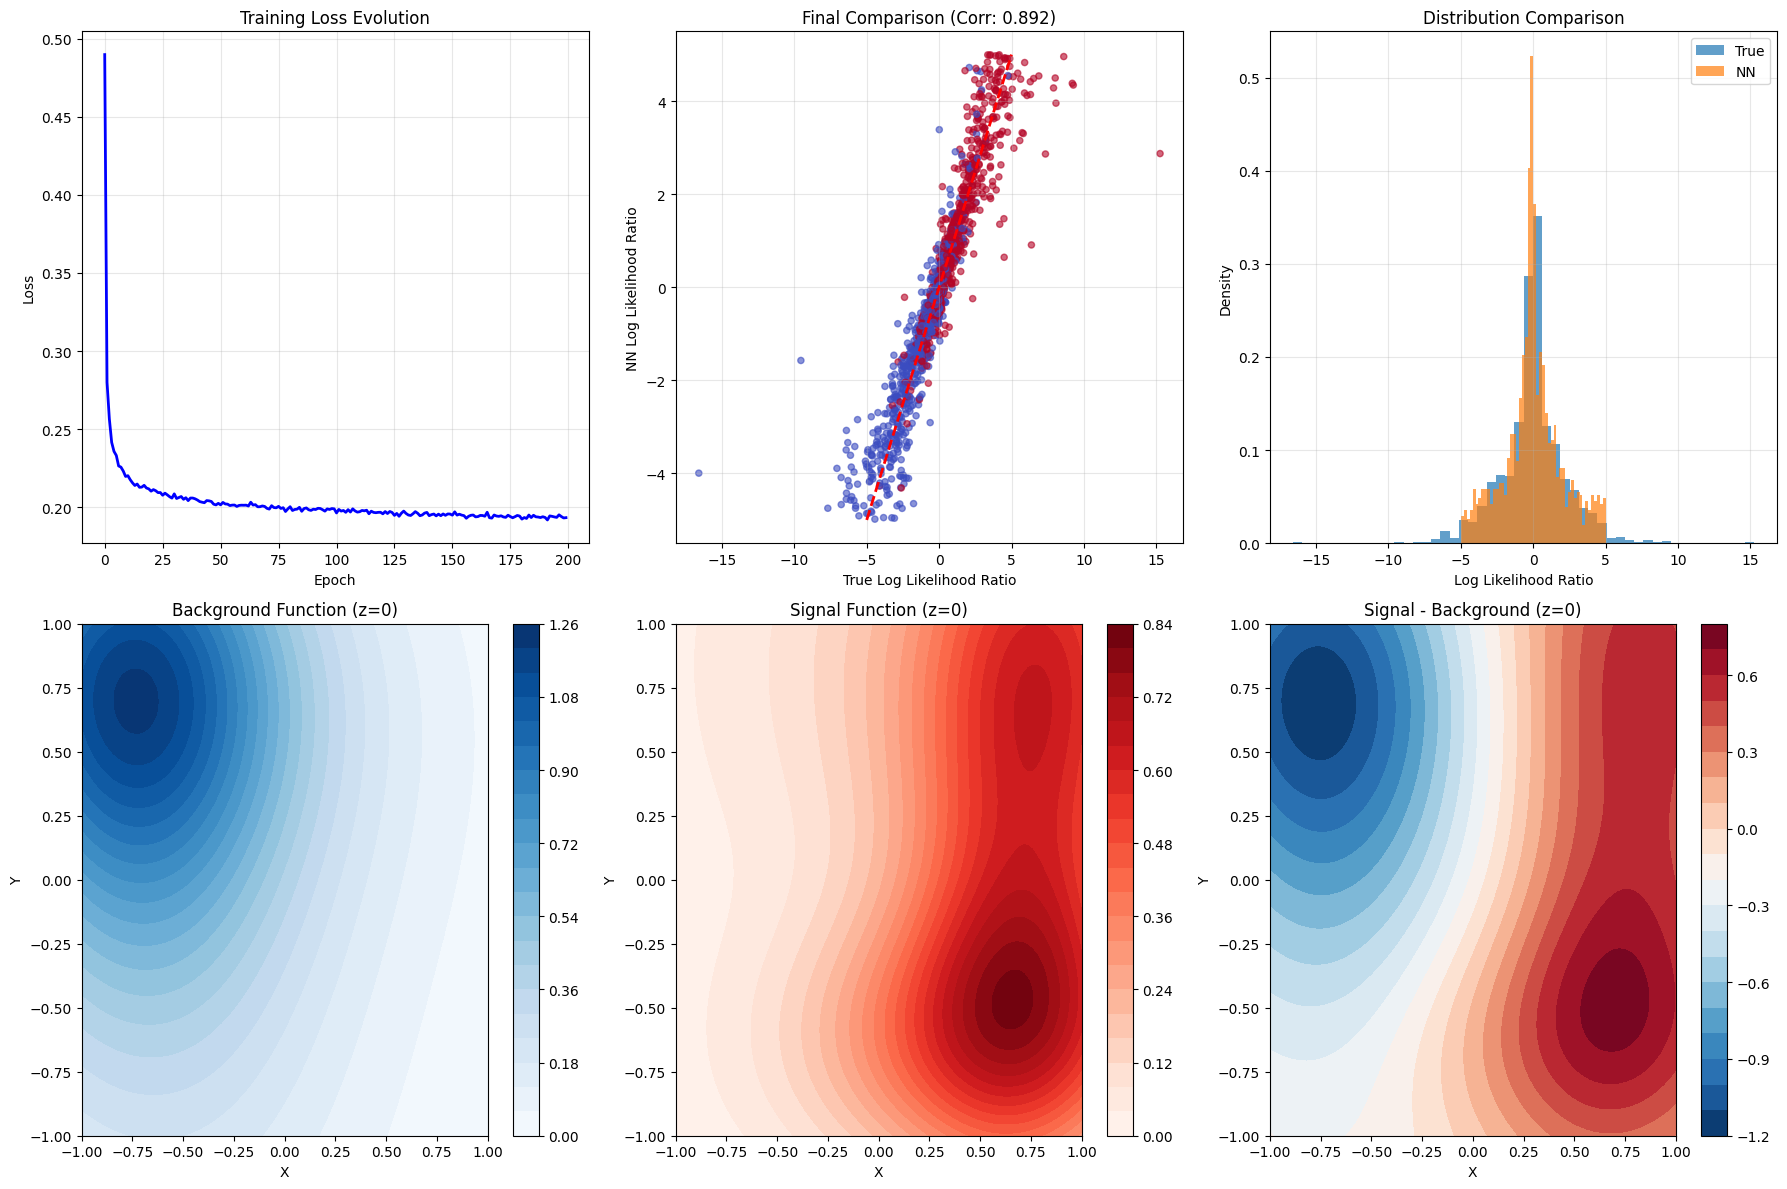

\nAnalysis complete! Check the 'nn_test_outputs' folder for saved plots and GIF.


In [11]:
# Final evaluation and analysis
print("FINAL EVALUATION")
print("=" * 60)

model.eval()
with torch.no_grad():
    # Final predictions
    final_outputs = model(X_test).squeeze()
    final_predictions = (final_outputs > 0.5).float()
    final_accuracy = (final_predictions == y_test).float().mean().item()
    
    # Final likelihood ratio predictions
    final_nn_log_ratios = model.predict_log_likelihood_ratio(X_test).squeeze()
    final_correlation = torch.corrcoef(torch.stack([true_log_ratios, final_nn_log_ratios]))[0, 1].item()
    
    # Calculate MSE between true and predicted log ratios
    mse_log_ratio = torch.mean((true_log_ratios - final_nn_log_ratios) ** 2).item()
    
    # Calculate classification metrics
    from sklearn.metrics import classification_report, confusion_matrix
    
    y_test_np = y_test.cpu().numpy()
    final_predictions_np = final_predictions.cpu().numpy()
    
    print(f"Final Test Accuracy: {final_accuracy:.4f}")
    print(f"Final Correlation (True vs NN Log Ratios): {final_correlation:.4f}")
    print(f"MSE of Log Likelihood Ratios: {mse_log_ratio:.4f}")
    print()
    
    print("Classification Report:")
    print(classification_report(y_test_np, final_predictions_np, 
                              target_names=['Background', 'Signal']))
    
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test_np, final_predictions_np)
    print(cm)
    
    # Create final comprehensive plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Final loss curve
    axes[0, 0].plot(losses, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss Evolution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: True vs NN likelihood ratios
    mask = (np.abs(final_nn_log_ratios.cpu().numpy()) < 5)
    axes[0, 1].scatter(true_log_ratios.cpu().numpy()[mask], final_nn_log_ratios.cpu().numpy()[mask], 
                      alpha=0.6, s=20, c=y_test.cpu().numpy()[mask], cmap='coolwarm')
    # min_val = min(true_log_ratios.min().item(), final_nn_log_ratios.min().item())
    # max_val = max(true_log_ratios.max().item(), final_nn_log_ratios.max().item())
    # min_val = min(min(final_nn_log_ratios.cpu().numpy()[mask]), true_log_ratios.cpu().numpy()[mask].min())
    # max_val = max(max(final_nn_log_ratios.cpu().numpy()[mask]), true_log_ratios.cpu().numpy()[mask].max())
    min_val = -5
    max_val = 5
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    axes[0, 1].set_xlabel('True Log Likelihood Ratio')
    axes[0, 1].set_ylabel('NN Log Likelihood Ratio')
    axes[0, 1].set_title(f'Final Comparison (Corr: {final_correlation:.3f})')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Histogram of likelihood ratios
    axes[0, 2].hist(true_log_ratios.cpu().numpy()[mask], bins=50, alpha=0.7, label='True', density=True)
    axes[0, 2].hist(final_nn_log_ratios.cpu().numpy()[mask], bins=50, alpha=0.7, label='NN', density=True)
    axes[0, 2].set_xlabel('Log Likelihood Ratio')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].set_title('Distribution Comparison')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Background vs Signal function visualizations
    x_viz = torch.linspace(-surrogate_gen.half_domain, surrogate_gen.half_domain, 100)
    y_viz = torch.linspace(-surrogate_gen.half_domain, surrogate_gen.half_domain, 100)
    X_viz, Y_viz = torch.meshgrid(x_viz, y_viz, indexing='ij')
    Z_viz = torch.zeros_like(X_viz)
    positions_viz = torch.stack([X_viz.flatten(), Y_viz.flatten(), Z_viz.flatten()], dim=1).to(device)
    
    bg_vals = surrogate_gen.evaluate_function(positions_viz, background_components).cpu().numpy().reshape(100, 100)
    sig_vals = surrogate_gen.evaluate_function(positions_viz, signal_components).cpu().numpy().reshape(100, 100)
    
    im1 = axes[1, 0].contourf(X_viz.cpu().numpy(), Y_viz.cpu().numpy(), bg_vals, levels=20, cmap='Blues')
    axes[1, 0].set_title('Background Function (z=0)')
    axes[1, 0].set_xlabel('X')
    axes[1, 0].set_ylabel('Y')
    plt.colorbar(im1, ax=axes[1, 0])
    
    im2 = axes[1, 1].contourf(X_viz.cpu().numpy(), Y_viz.cpu().numpy(), sig_vals, levels=20, cmap='Reds')
    axes[1, 1].set_title('Signal Function (z=0)')
    axes[1, 1].set_xlabel('X')
    axes[1, 1].set_ylabel('Y')
    plt.colorbar(im2, ax=axes[1, 1])
    
    # Plot 6: Difference between signal and background
    diff_vals = sig_vals - bg_vals
    im3 = axes[1, 2].contourf(X_viz.cpu().numpy(), Y_viz.cpu().numpy(), diff_vals, levels=20, cmap='RdBu_r')
    axes[1, 2].set_title('Signal - Background (z=0)')
    axes[1, 2].set_xlabel('X')
    axes[1, 2].set_ylabel('Y')
    plt.colorbar(im3, ax=axes[1, 2])
    
    plt.tight_layout()
    plt.savefig('nn_test_outputs/final_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
print("\\nAnalysis complete! Check the 'nn_test_outputs' folder for saved plots and GIF.")
print("=" * 60)

# MLP Neural Network Likelihood Ratio Test

## Experiment Overview

This notebook implements a comprehensive test of using a Multi-Layer Perceptron (MLP) neural network to approximate likelihood ratios for signal vs background classification. 

### Key Components:

1. **Surrogate Functions**: 
   - Background and signal functions are generated as superpositions of 10 randomly parameterized Gaussian functions
   - Each function maps 3D position to light yield
   - Similar to the approach used in GeoOptimizer.py

2. **Data Generation**:
   - Sample 3D positions uniformly in the domain
   - Evaluate surrogate functions at these positions to get mean light yields
   - Add Gaussian noise to simulate realistic measurements
   - Create balanced dataset with background (label=0) and signal (label=1) samples

3. **Neural Network**:
   - Input: 4D feature vector (x, y, z, light_yield)
   - Architecture: Fully connected layers with ReLU activations and dropout
   - Output: Sigmoid activation giving probability of being signal
   - Loss: Binary Cross Entropy

4. **Likelihood Ratio Approximation**:
   - Transform NN output p using log(p/(1-p)) to approximate log likelihood ratio
   - Compare with true likelihood ratio computed from known Gaussian noise model

5. **Visualization**:
   - Real-time loss evolution during training
   - Scatter plots comparing true vs NN likelihood ratios
   - 2D contour plots showing likelihood ratio iso-contours
   - Generation of training evolution GIF

### Expected Results:

- The neural network should learn to classify background vs signal samples
- The log likelihood ratio approximation should correlate well with the true values
- Contour plots should show similar patterns between true and NN likelihood ratios
- The training evolution GIF should demonstrate convergence over epochs

This test validates whether neural networks can effectively learn likelihood ratios from data, which has applications in physics analysis, anomaly detection, and statistical inference.